## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
def gaussian(x, m=0., s=1.0):
    out = 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*s**2.))
    return out / out.sum() / (x[1] - x[0])

In [3]:
x = np.arange(-15, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

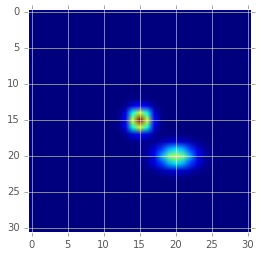

In [5]:
from scipy.stats import multivariate_normal

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#x, y = np.mgrid[-15:16:1, -15:16:1]
#grid = np.dstack((x, y))
g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
plt.imshow(g1)

## Update: it looks like the actual code uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

In [56]:
# This code works, but I think the next cell is faster.
from numpy.polynomial.chebyshev import chebgrid2d

h0 = chebgrid2d(x, y, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebgrid2d(x, y, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 0, 1]])

In [55]:
from numpy.polynomial.chebyshev import chebval2d
h0 = chebval2d(x0, y0, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebval2d(x0, y0, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 0, 1]])

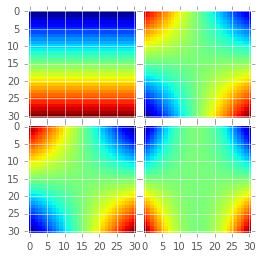

In [57]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
igrid[0].imshow(h0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(h1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(h2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(h3, interpolation='none')  # The AxesGrid object work as a list of axes.

In [9]:
## The following code does exactly the same as the above:
from numpy.polynomial.chebyshev import chebval
def chebval2d_try(x, y, xord, yord):
    cx = chebval(x, xord)
    cy = chebval(y, yord)
    h0 = np.outer(cx, cy)
    return h0

if False:
    #h0 = chebval2d_try(x, y, [1, 0, 0], [0, 1, 0])
    h0 = chebval2d_try(x, y, [0, 1, 0], [0, 1, 0])
    #h0 = chebval2d_try(x, y, [0, 1, 0], [0, 0, 1])
    print h0.shape
    plt.imshow(h0)

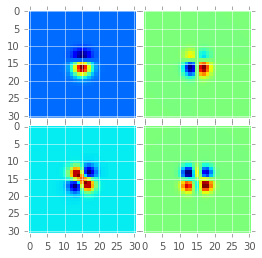

In [10]:
gh0 = gaussian2d(grid, s=[3., 3.]) * h0
gh1 = gaussian2d(grid, s=[3., 3.]) * h1
gh2 = gaussian2d(grid, s=[3., 3.]) * h2
gh3 = gaussian2d(grid, s=[3., 3.]) * h3
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
extent = (x0.min(), x0.max(), y0.min(), y0.max())
igrid[0].imshow(gh0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(gh1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(gh2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(gh3, interpolation='none')  # The AxesGrid object work as a list of axes.

## Generate AL basis funcs now...

use same parameters as from the stack.

TBD: is a degGauss of 2 mean it goes up to order 2 (i.e. $x^2$)? Or is it 2 orders so it only goes up to linear ($x$)? Probably the former, so that's what we'll use.

In [117]:
# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 1   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebGauss2d(x, y, grid, m=None, s=None, ord=[0,0], beta=1., verbose=False):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print s, ord, coef0, coef1
    ga = gaussian2d(grid, m, np.array(s)/beta)
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch * ga

In [118]:
basis = [chebGauss2d(x0, y0, grid, m=[0,0], s=[sig0,sig1], ord=[deg0,deg1], beta=betaGauss, verbose=True) for i0,sig0 in enumerate(sigGauss) for i1,sig1 in enumerate(sigGauss) for deg0 in range(degGauss[i0]+1) for deg1 in range(degGauss[i1]+1)]
print len(basis), basis[0].shape, x0.shape, grid.shape, basis[0].reshape(x0.shape).shape

[0.75, 0.75] [0, 0] [ 1.] [ 1.]
[0.75, 0.75] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 0.75] [0, 2] [ 1.  0.  0.] [ 0.  0.  1.]
[0.75, 0.75] [0, 3] [ 1.  0.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [0, 4] [ 1.  0.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 0.75] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 0.75] [1, 2] [ 0.  1.  0.] [ 0.  0.  1.]
[0.75, 0.75] [1, 3] [ 0.  1.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [1, 4] [ 0.  1.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 0.75] [2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[0.75, 0.75] [2, 2] [ 0.  0.  1.] [ 0.  0.  1.]
[0.75, 0.75] [2, 3] [ 0.  0.  1.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [2, 4] [ 0.  0.  1.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [3, 0] [ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[0.75, 0.75] [3, 1] [ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[0.75, 0.75] [3, 2] [ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[0.75, 0.75] [3, 3] [ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[0.75, 0.75] [3, 4] [ 0.

In [142]:
print len(basis), basis[0].shape, basis[0].reshape(x0.shape).shape, 31*31
basis2 = np.dstack(basis).T  # put the bases into an array
print basis2.shape, basis2[0].shape, basis2[0].reshape(x0.shape).shape
print basis[0].min(), basis[0].max(), basis2.min(), basis2.max()

121 (31, 31) (31, 31) 961
(121, 31, 31) (31, 31) (31, 31)
1.0924820179e-131 0.212206590789 -14.1624248714 14.1624248714


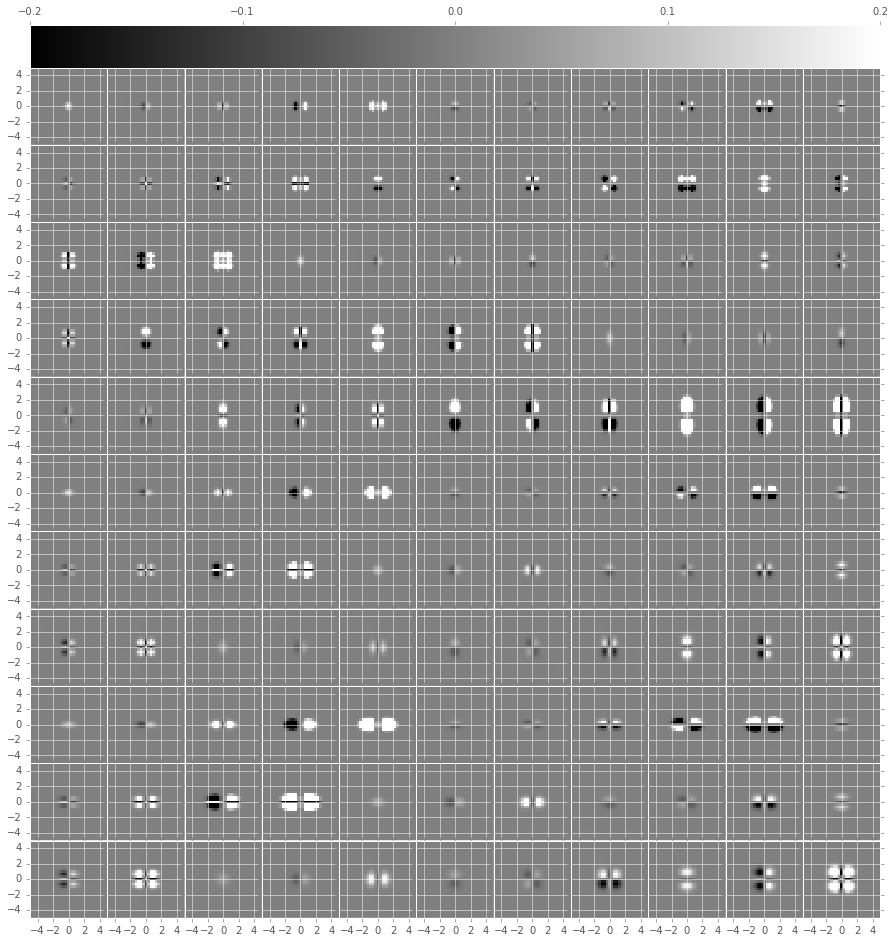

In [144]:
limits = [-0.2, 0.2] #[basis2.min(), basis2.max()]
fig = plt.figure(1, (16., 16.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(11, 11),  # creates 2x2 grid of axes
                    axes_pad=0.0,
                    share_all=True,
                    label_mode="L",
                    cbar_location="top",
                    cbar_mode="single"
                 )
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
for i in range(121):
    gim = igrid[i].imshow(basis[i].reshape(x0.shape), origin='lower', interpolation='none', cmap='gray', extent=extent,
                         vmin=limits[0], vmax=limits[1])
igrid.cbar_axes[0].colorbar(gim)

Make the two "images". `im1` is the template, `im2` is the science image.

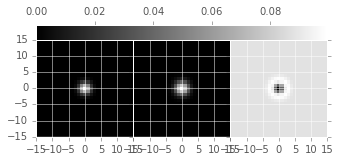

In [205]:
psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image
im1 = gaussian2d(grid, m=[0,0], s=[psf1, psf1])
im2 = gaussian2d(grid, m=[0,0], s=[psf2, psf2])
fig = plt.figure(1, (6, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0.min(), x0.max(), y0.min(), y0.max())
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2-im1, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid.cbar_axes[0].colorbar(gim)

Convolve im2 with the basis functions, and make these the *new* bases.

(31, 31) (31, 31)
(31, 31) -0.0877360164747 0.0877360164747


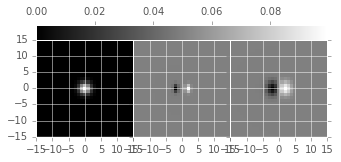

In [206]:
# Test convolve template with the first basis
import scipy.ndimage.filters
print im2.shape, basis[3].shape
tmp = scipy.ndimage.filters.convolve(im1, basis[3], mode='constant')
print tmp.shape, tmp.min(), tmp.max()
fig = plt.figure(1, (6, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0.min(), x0.max(), y0.min(), y0.max())
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(basis[3], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(tmp, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid.cbar_axes[0].colorbar(gim)

In [207]:
basis2 = [scipy.ndimage.filters.convolve(im1, b, mode='constant') for b in basis]
print len(basis2), basis2[0].shape

basis2a = np.vstack([b.flatten() for b in basis2]).T
print basis2a.shape, im2.flatten().shape

121 (31, 31)
(961, 121) (961,)


Do the linear fit to compute the matching kernel. The resulting fit is the convolved diffim.

[  4.34829892e-12] 0.0120664765006 0.0021417619669
[ -9.22657173e+02  -2.15620704e-06  -1.52050437e+01  -5.84918780e-11
  -1.08612902e+00   9.10605053e-07  -6.27807140e-10   9.10511631e-08
  -1.81747950e-11   2.02082678e-09  -1.52050378e+01  -2.15881097e-07
   6.33207731e+00  -3.01915423e-11   7.35217181e-02  -3.72400266e-12
  -2.51430238e-11   7.27039294e-12  -1.41917593e-13   6.28046511e-13
  -1.08612902e+00  -4.98761973e-09   7.35217050e-02   1.45605513e-12
  -2.40607344e-05   6.06974776e+02   2.87248175e-06  -4.13450125e+01
  -1.52919177e-08   4.12441481e-10  -1.73176170e-09  -3.26358338e+01
  -1.51904045e-07   2.22745224e+00   3.93654774e-12  -1.16852959e-11
   1.56437816e-12   4.24675907e-01   2.06236688e-09  -2.86416356e-02
  -7.25336034e+01  -3.83469296e-07   4.81932491e+00   3.74409330e-09
   4.17986654e-11   4.26330956e-10   1.30007706e+00   7.01566578e-09
  -8.66827971e-02   3.67394481e-13  -2.79569772e-13  -2.71067763e-13
  -2.89737149e-03  -1.59486328e-11   1.95408917e-04 

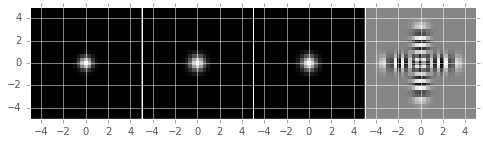

In [208]:
pars, resid, _, _ = np.linalg.lstsq(basis2a, im2.flatten())
print resid, np.sum((im2 - fit.reshape(im2.shape))**2), np.sum((im2 - im1)**2)
print pars
fit = (pars * basis2a).sum(1).reshape(im2.shape)
print basis2a.shape, fit.shape

fig = plt.figure(1, (8, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow(im2 - fit, origin='lower', interpolation='none', cmap='gray', extent=extent)
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit, axis=None)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

0.999996295521


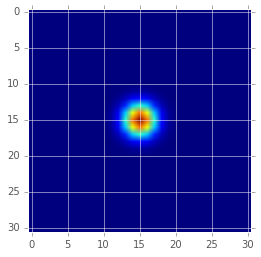

In [209]:
kfit = (pars * basis2a).sum(1).reshape(im2.shape)
print kfit.sum()
kfit /= kfit.sum()
plt.imshow(kfit)  # this plots the matching kernel

Compare the convolved template to the science image. Also plot the new diffim for comparison.

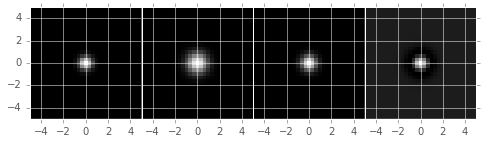

In [210]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit, mode='constant')
fig = plt.figure(1, (8, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow(im2 - conv_im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # diffim (grey)

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3 (and above), although it gives identical results.

(121,)
(121, 121)
[  2.49121399e-01   4.90011308e-03  -1.11704378e-01  -1.98750643e-05
  -1.07755383e-02  -5.74003357e-04  -2.45628197e-03   4.50768124e-03
  -1.34567581e-04   4.45033428e-05  -1.12198827e-01   4.31320724e-03
   4.41525645e-02   2.39179512e-04   1.02861646e-03  -4.68261901e-05
  -5.77791229e-05   3.08012357e-04   1.69490857e-07  -6.49302962e-06
  -1.07399295e-02   6.83686872e-05   1.15878801e-03  -7.48029261e-06
  -5.74418511e-05   1.95539465e-01  -3.94004146e-03  -8.87791626e-02
   6.30228649e-04   7.18074868e-04  -4.12223223e-03   2.27861863e-02
  -9.72780849e-04  -6.32515730e-03  -2.94078332e-05  -2.62633390e-05
   1.08776907e-04  -2.85705157e-03   3.18071806e-05   2.74173154e-04
   1.53628367e-01  -2.96299633e-03  -6.62797514e-02  -2.02871330e-03
   1.42644696e-04  -6.02446145e-04   7.58926766e-03   1.08920988e-04
   7.62025743e-04  -1.08631700e-06  -9.73488434e-07   4.01996013e-06
  -3.57591406e-05  -1.14759193e-06   3.01291960e-06   1.97009674e-01
   3.82305209e-0

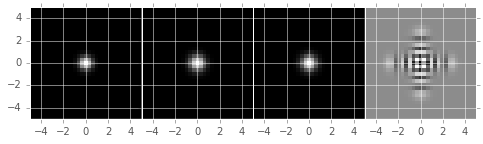

In [212]:
b = (basis2a.T * im2.flatten()).sum(1)
print b.shape

M = np.dot(basis2a.T, basis2a)
print M.shape

pars2, resid, _, _ = np.linalg.lstsq(M, b)
print pars2
#print 'Difference (log10):\n', np.log10(np.abs((pars2-pars)/pars2))

fit2 = (pars2 * basis2a).sum(1).reshape(im1.shape)
print basis2a.shape, fit2.shape

fig = plt.figure(1, (8, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit2, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow(im2 - fit2, origin='lower', interpolation='none', cmap='gray', extent=extent)
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit2, axis=None)
#print pars2-pars

0.99999173078


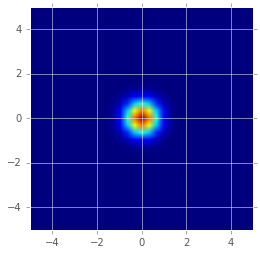

In [215]:
kfit2 = (pars2 * basis2a).sum(1).reshape(im2.shape)
print kfit2.sum()
kfit2 /= kfit2.sum()
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(kfit2, extent=extent)  # this plots the matching kernel

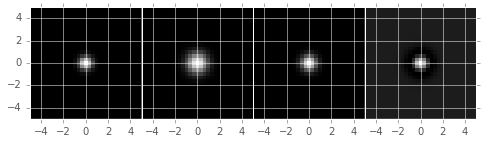

In [214]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit2, mode='constant')
fig = plt.figure(1, (8, 2))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
gim = igrid[0].imshow(im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2, origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow(im2 - conv_im1, origin='lower', interpolation='none', cmap='gray', extent=extent) # diffim (grey)

Add taking into account PSF variations... (next notebook, #4)